# **Flower Classification with CNNs and Transfer Learning: EfficientNet**


# Import Libraries

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import requests
from PIL import Image
from io import BytesIO

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.models import Model

import os
import random
import shutil
import cv2
from tqdm import tqdm
from skimage.io import imread

# Data Preprocessing and Splitting for Flower Classification

In [8]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

X = []
Z = []

def assign_label(flower_type):
    if flower_type == 'daisy':
        return 1
    elif flower_type == 'dandelion':
        return 2
    elif flower_type == 'rose':
        return 3
    elif flower_type == 'sunflower':
        return 4
    elif flower_type == 'tulip':   
        return 0

inputdataset = "/kaggle/input/flowers-recognition/flowers"

for flower in os.listdir(inputdataset):
    flower_path = os.path.join(inputdataset, flower)  

    if not os.path.isdir(flower_path):  
        continue

    for filename in os.listdir(flower_path):
        img_path = os.path.join(flower_path, filename)  
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img is None:  
            print(f"Warning: {img_path} could not be loaded.")
            continue

        img = cv2.resize(img, (224, 224))
        label = assign_label(flower)  
        X.append(np.array(img / 255))  
        Z.append(label)

X = np.array(X)
Z = np.array(Z)

Y = to_categorical(Z, 5)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (3453, 224, 224, 3)
x_test shape:  (864, 224, 224, 3)
y_train shape:  (3453, 5)
y_test shape:  (864, 5)


# Data Visualization

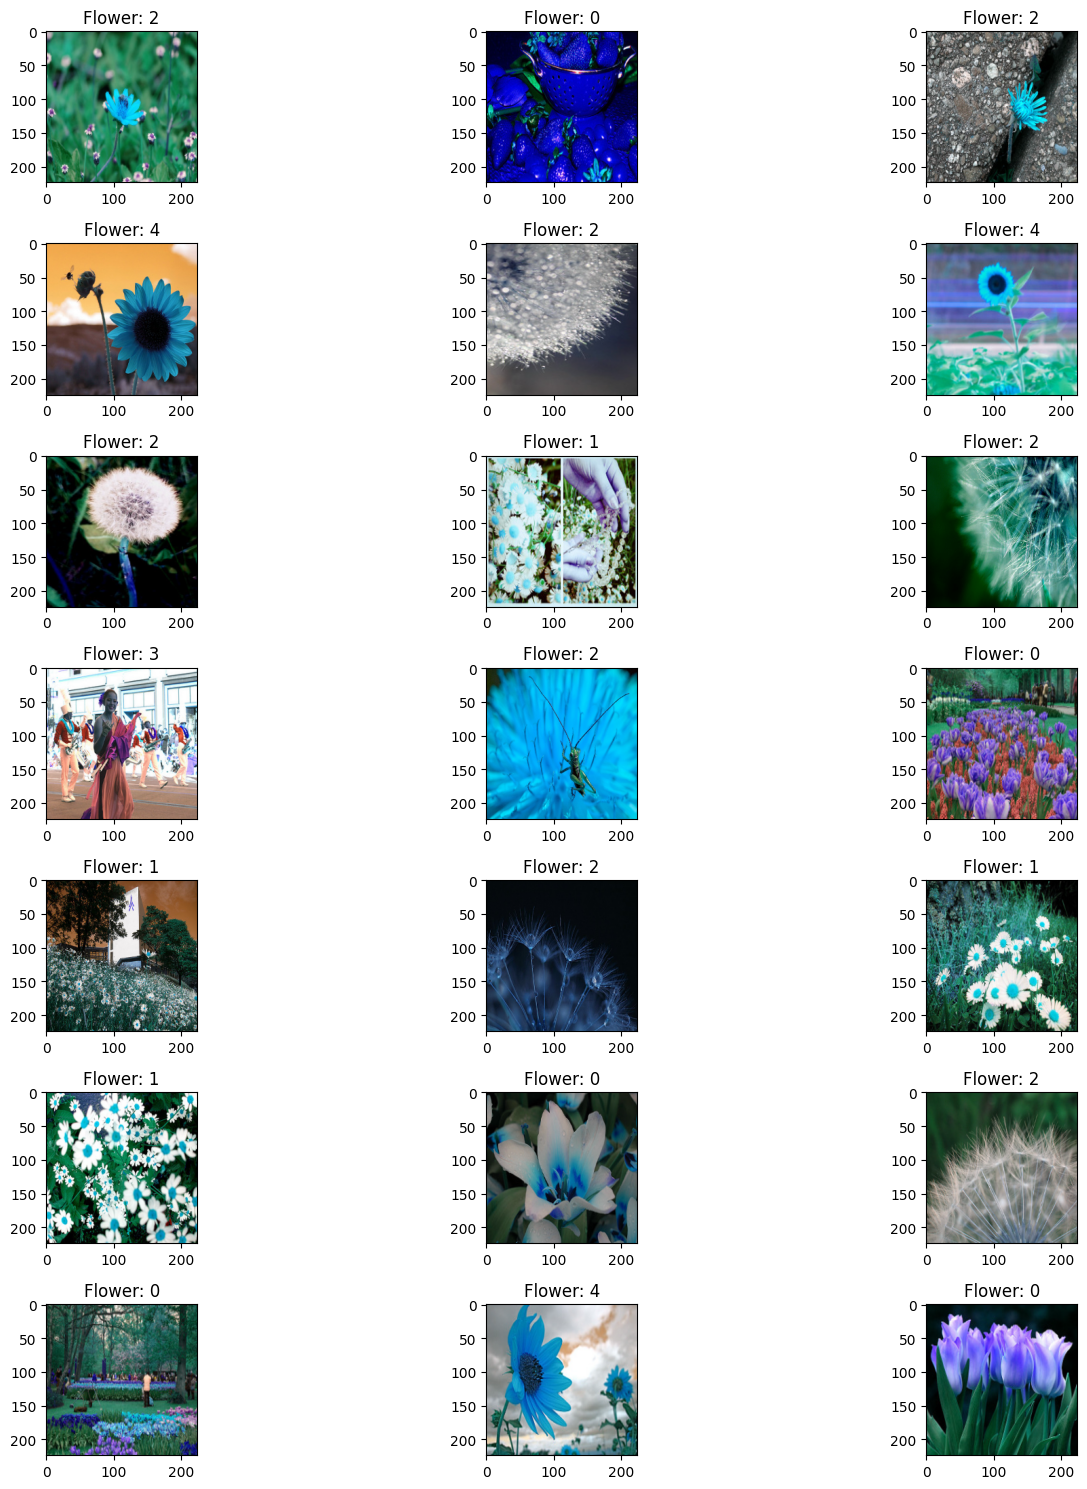

In [9]:
figure, axes = plt.subplots(7, 3)
figure.set_size_inches(15, 15)

for row in range(7):
    for col in range(3):
        index = random.randint(0, len(X) - 1)   

        image = X[index]
        flower_label = Z[index]        

        axes[row, col].imshow(image)
        axes[row, col].set_title(f"Flower: {flower_label}")

plt.tight_layout()
plt.show()

# Count of Flowers by Class

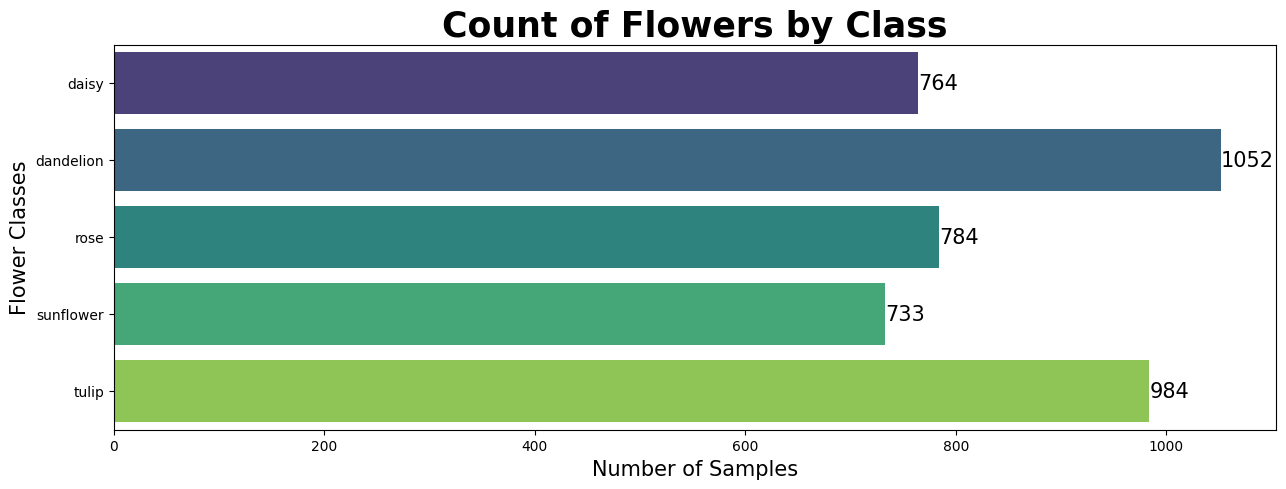

In [10]:
flower_counts = []

for flower_class in classes:
    class_path = os.path.join(inputdataset, flower_class)
    flower_counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(15, 5))
bar_plot = sns.barplot(x=flower_counts, y=classes, palette="viridis")
bar_plot.bar_label(bar_plot.containers[0], fontsize=15)

plt.title("Count of Flowers by Class", fontsize=25, fontweight="bold")
plt.xlabel("Number of Samples", fontsize=15)
plt.ylabel("Flower Classes", fontsize=15)

plt.show()

## Image Preprocessing and Feature Extraction

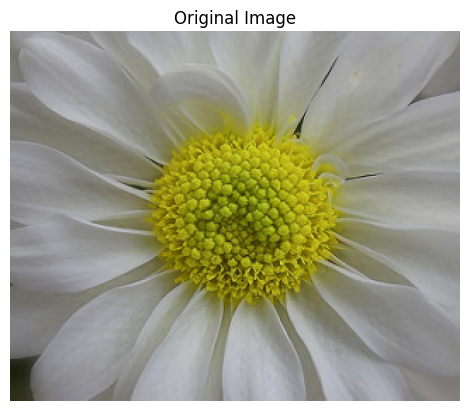

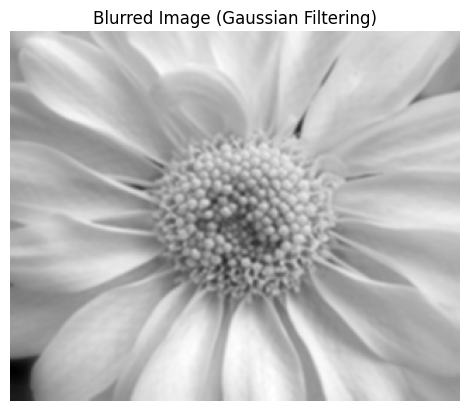

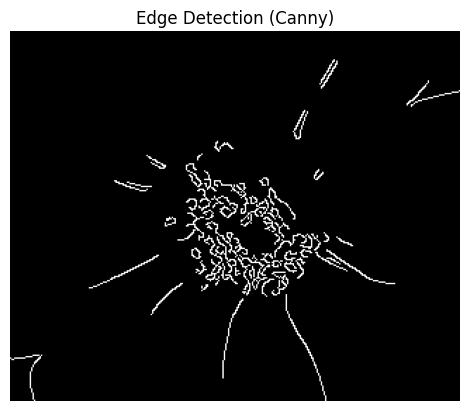

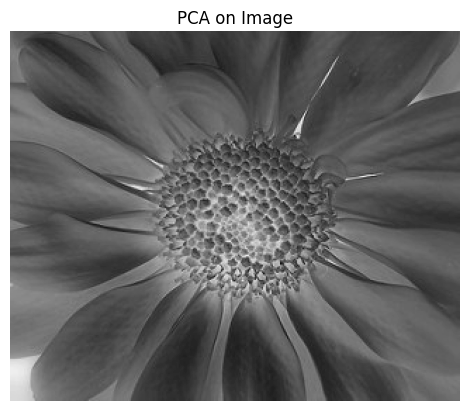

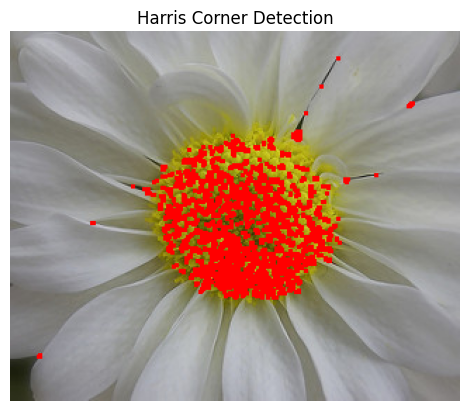

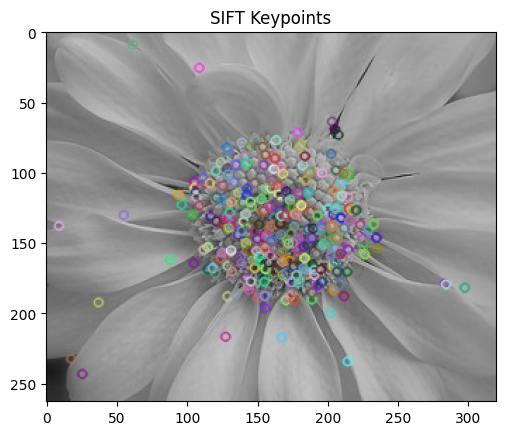

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Load the Image
image_path = "/kaggle/input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg"
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")  # Hide the axis
plt.show()

# Step 2: Image Filtering (Smoothing)
blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred Image (Gaussian Filtering)")
plt.axis("off")  # Hide the axis
plt.show()

# Step 3: Edge Detection (Canny)
edges = cv2.Canny(blurred_image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Canny)")
plt.axis("off")  # Hide the axis
plt.show()

# Step 4: Principal Component Analysis (PCA)
# Reshape the image for PCA
reshaped_image = gray.reshape(-1, 1)
pca = PCA(n_components=1)
pca_transformed = pca.fit_transform(reshaped_image)
pca_image = pca_transformed.reshape(gray.shape)

# Display PCA result
plt.imshow(pca_image, cmap='gray')
plt.title("PCA on Image")
plt.axis("off")  # Hide the axis
plt.show()

# Step 5: Corner Detection (Harris Corner Detection)
corners = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
corners = cv2.dilate(corners, None)  # Dilate to mark the corners

# Create a copy of the image to display corners
image_with_corners = image.copy()
image_with_corners[corners > 0.01 * corners.max()] = [0, 0, 255]

# Display corners on the image
plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
plt.title("Harris Corner Detection")
plt.axis("off")  # Hide the axis
plt.show()

# Step 6: Initialize the SIFT detector
sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(gray, None)

sift_image = cv2.drawKeypoints(gray, keypoints, None)
plt.imshow(sift_image)
plt.title('SIFT Keypoints')
plt.show()


# Building and Training the CNN Model with Data Augmentation

In [12]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

In [13]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.25))

cnn_model.add(Dense(5, activation='softmax')) 

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
cnnmodel_history = cnn_model.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=30, 
                    validation_data=(x_test, y_test))

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.3807 - loss: 1.4275 - val_accuracy: 0.5382 - val_loss: 1.1467
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.5463 - loss: 1.1153 - val_accuracy: 0.6389 - val_loss: 0.9431
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.5894 - loss: 1.0162 - val_accuracy: 0.6435 - val_loss: 0.9068
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6244 - loss: 0.9760 - val_accuracy: 0.6817 - val_loss: 0.8872
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.6563 - loss: 0.9060 - val_accuracy: 0.7060 - val_loss: 0.8348
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.6655 - loss: 0.8509 - val_accuracy: 0.6910 - val_loss: 0.8256
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.6970 - loss: 0.8035 - val_accuracy: 0.6979 - val_loss: 0.8026
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.6761 - loss: 0.8297 - val_accu

# Evaluate the CNN Model Performance

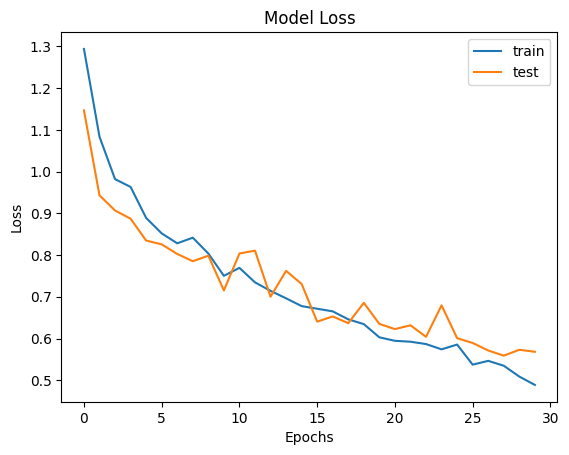

In [15]:
plt.plot(cnnmodel_history.history['loss'])
plt.plot(cnnmodel_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

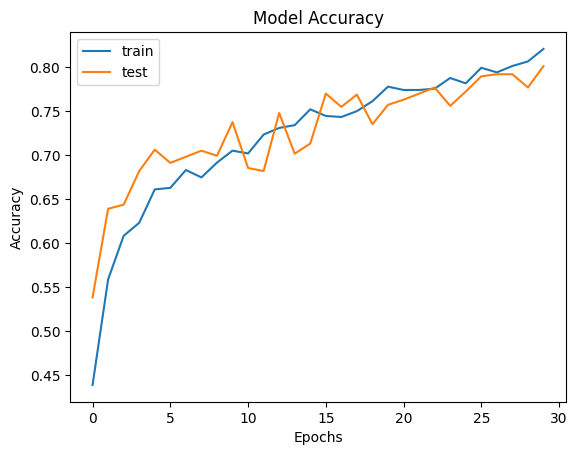

In [16]:
plt.plot(cnnmodel_history.history['accuracy'])
plt.plot(cnnmodel_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [17]:
loss, accuracy =cnn_model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = cnn_model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy:  0.8581
Testing Accuracy:  0.8009


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 485ms/step
Classification Report
              precision    recall  f1-score   support

       Daisy       0.77      0.76      0.77       179
   Dandelion       0.78      0.85      0.81       161
        Rose       0.89      0.83      0.86       224
   Sunflower       0.75      0.64      0.69       156
       Tulip       0.78      0.92      0.85       144

    accuracy                           0.80       864
   macro avg       0.79      0.80      0.80       864
weighted avg       0.80      0.80      0.80       864



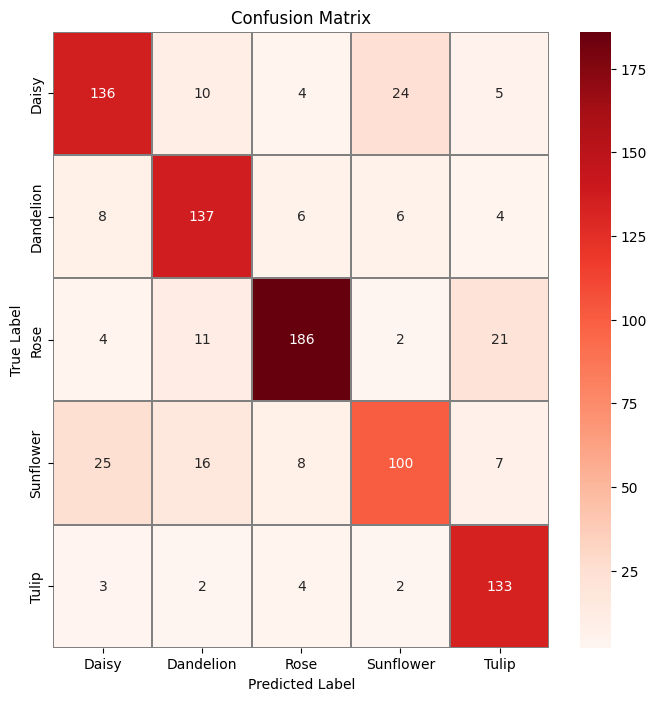

In [18]:
Y_pred = cnn_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

print("Classification Report")

target_names = ["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"]  
print(classification_report(Y_true, Y_pred_classes, target_names=target_names))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, cmap="Reds", linecolor='gray', linewidth=0.01, annot=True, fmt='d',

            xticklabels=target_names, yticklabels=target_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualizing Predictions

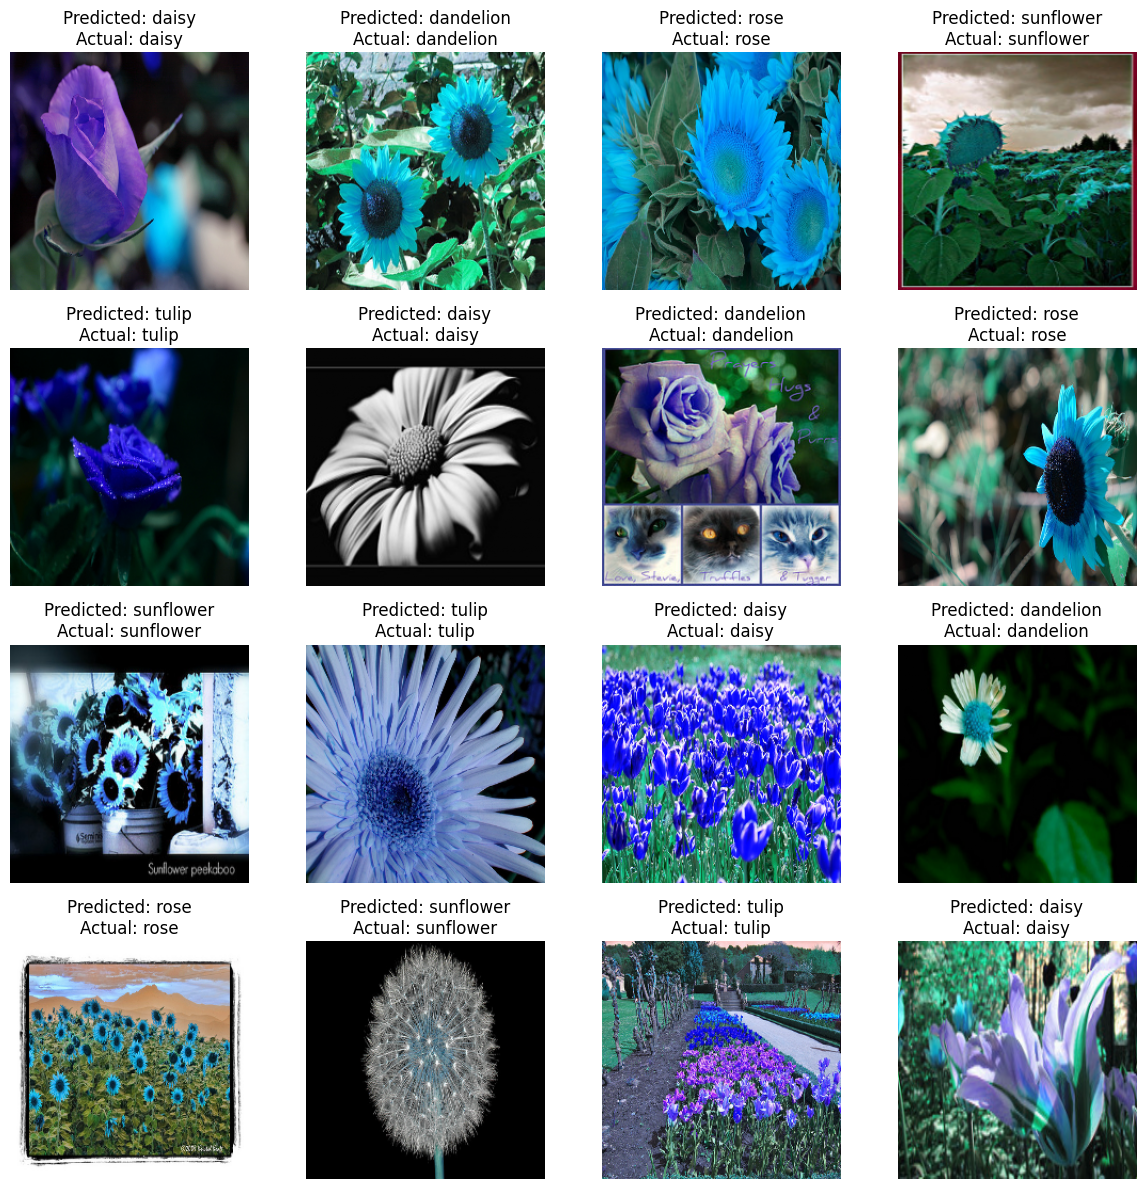

In [19]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# For demonstration, let's assume you have these class labels from your dataset
# Replace this with the actual labels from your dataset
Y_train = ['daisy', 'rose', 'tulip', 'sunflower', 'dandelion'] * 100  # Example labels

# Instantiate and fit LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(Y_train)  # Fit the encoder on the available class labels

# Assuming Y_pred_classes and Y_true are already available
# Y_pred_classes and Y_true should be numerical labels that your model predicts and actual true labels
# Replace these with actual values from your test dataset/model
Y_pred_classes = [0, 1, 2, 3, 4] * 16  # Example predicted labels
Y_true = [0, 1, 2, 3, 4] * 16  # Example true labels

# Plot the first 16 test images with predicted and actual labels
plt.figure(figsize=(12, 12))

for i in range(16):  
    plt.subplot(4, 4, i + 1)  # Create a 4x4 grid of subplots
    plt.imshow(x_test[i])  # Display the image from x_test

    # Add title with both predicted and actual flower names
    plt.title(
        f"Predicted: {labelEncoder.inverse_transform([Y_pred_classes[i]])[0]}\n" +
        f"Actual: {labelEncoder.inverse_transform([Y_true[i]])[0]}"
    )
    plt.axis('off')  # Hide the axis

plt.tight_layout()  # Adjust the layout to avoid overlapping
plt.show()


# Tranfer Learning

## Flowers Classification with EfficientNetB3 Model

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_data = train_datagen.flow(x_train, y_train, batch_size=32)
test_data = test_datagen.flow(x_test, y_test, batch_size=32)

In [21]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

weights_path = '/kaggle/input/shreelende/efficientnetb3_notop.h5'

# Load the EfficientNetB3 model with the uploaded weights and without the top layer
base_model = EfficientNetB3(weights=weights_path, include_top=False, input_shape=(224, 224, 3))

# Add Global Average Pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a Dense layer for classification with 5 output classes
predictions = Dense(5, activation='softmax')(x)

# Create the model
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (adjust optimizer and learning rate as needed)
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Import necessary libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile the EfficientNet model with the specified parameters
efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001), 
                            loss='categorical_crossentropy', 
                            metrics=['accuracy'])

# Set up EarlyStopping callback to monitor validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with the specified number of epochs (6)
efficientnet_history = efficientnet_model.fit(train_data, 
                                               epochs=6, 
                                               validation_data=test_data, 
                                               callbacks=[early_stop])


Epoch 1/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1270s 11s/step - accuracy: 0.6256 - loss: 1.0081 - val_accuracy: 0.2593 - val_loss: 1.6712
Epoch 2/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1185s 11s/step - accuracy: 0.8827 - loss: 0.3421 - val_accuracy: 0.2118 - val_loss: 1.7192
Epoch 3/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1206s 11s/step - accuracy: 0.9266 - loss: 0.2246 - val_accuracy: 0.2604 - val_loss: 1.6774
Epoch 4/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1186s 11s/step - accuracy: 0.9467 - loss: 0.1591 - val_accuracy: 0.4722 - val_loss: 1.2970
Epoch 5/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1180s 11s/step - accuracy: 0.9503 - loss: 0.1453 - val_accuracy: 0.8252 - val_loss: 0.5398
Epoch 6/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1200s 11s/step - accuracy: 0.9773 - loss: 0.0775 - val_accuracy: 0.8924 - val_loss: 0.3711


In [41]:
import os
os.makedirs('/kaggle/working/shreelende', exist_ok=True)
efficientnet_model.save('/kaggle/working/shreelende/flowers_EfficientNetB3.h5')

In [24]:
loss, accuracy = efficientnet_model.evaluate(train_data)
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9228 - loss: 0.2326
Train Loss: 0.23365052044391632
Train Accuracy: 0.9194902777671814


In [25]:
loss, accuracy = efficientnet_model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8979 - loss: 0.3577
Test Loss: 0.3711264431476593
Test Accuracy: 0.8923611044883728


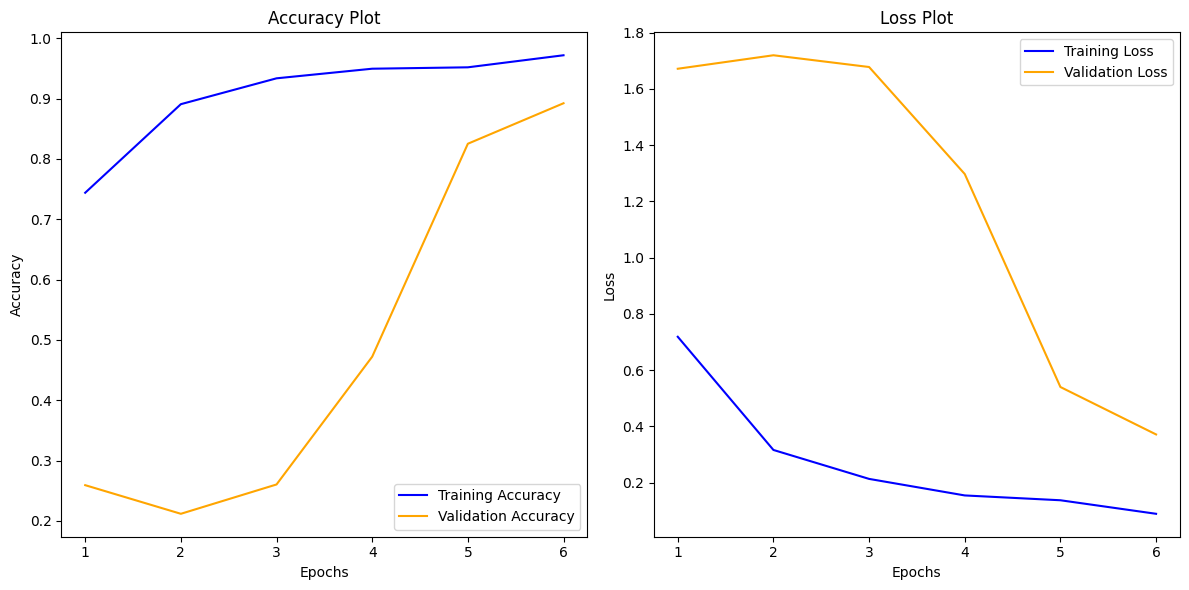

In [26]:
accuracy = efficientnet_history.history['accuracy']
val_accuracy = efficientnet_history.history['val_accuracy']
loss = efficientnet_history.history['loss']
val_loss = efficientnet_history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
y_pred_probs = efficientnet_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names = classes)
print(report)

27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
              precision    recall  f1-score   support

       daisy       0.93      0.75      0.83       179
   dandelion       0.92      0.87      0.89       161
        rose       0.94      0.96      0.95       224
   sunflower       0.77      0.96      0.85       156
       tulip       0.92      0.92      0.92       144

    accuracy                           0.89       864
   macro avg       0.90      0.89      0.89       864
weighted avg       0.90      0.89      0.89       864



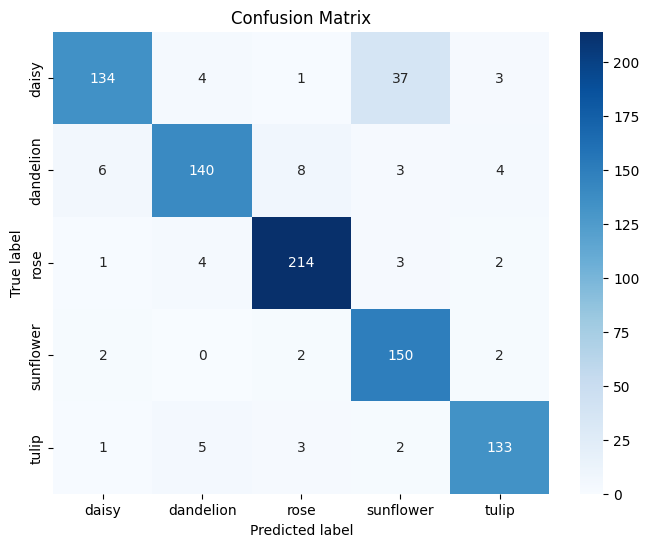

In [28]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Saving the Model

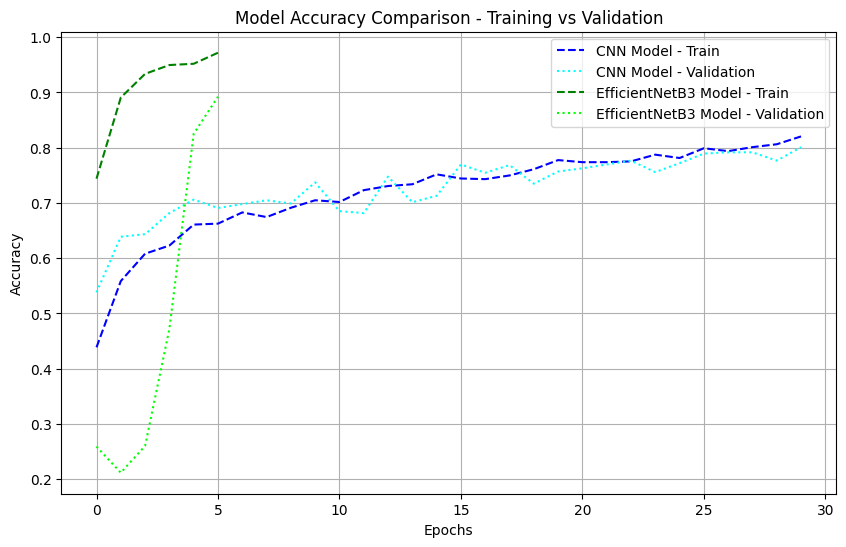

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(cnnmodel_history.history['accuracy'], label='CNN Model - Train', linestyle='--', color='blue')
plt.plot(cnnmodel_history.history['val_accuracy'], label='CNN Model - Validation', linestyle=':', color='cyan')
plt.plot(efficientnet_history.history['accuracy'], label='EfficientNetB3 Model - Train', linestyle='--', color='green')
plt.plot(efficientnet_history.history['val_accuracy'], label='EfficientNetB3 Model - Validation', linestyle=':', color='lime')
\
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison - Training vs Validation')
plt.legend()
plt.grid(True)

plt.show()

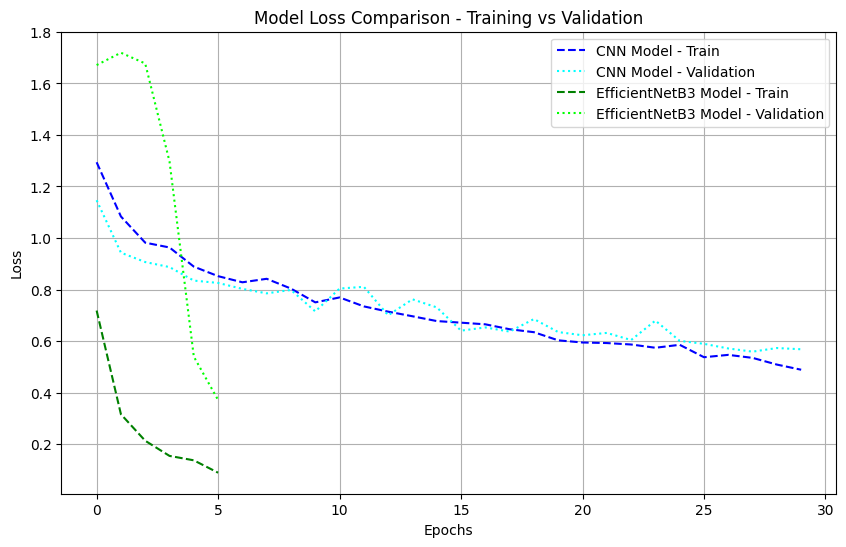

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(cnnmodel_history.history['loss'], label='CNN Model - Train', linestyle='--', color='blue')
plt.plot(cnnmodel_history.history['val_loss'], label='CNN Model - Validation', linestyle=':', color='cyan')
plt.plot(efficientnet_history.history['loss'], label='EfficientNetB3 Model - Train', linestyle='--', color='green')
plt.plot(efficientnet_history.history['val_loss'], label='EfficientNetB3 Model - Validation', linestyle=':', color='lime')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison - Training vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
from tensorflow import keras

final_model = keras.models.load_model('/kaggle/working/flowers_EfficientNetB3.keras')

In [45]:
from tensorflow.keras.saving import save_model

save_model(efficientnet_model, '/kaggle/working/flowers_EfficientNetB3.keras')

# Making A Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Label: daisy


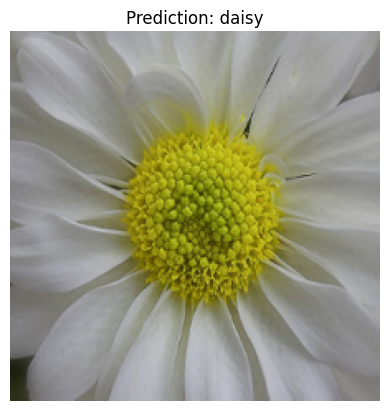

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the image
image_path = "/kaggle/input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg"

# Read the image using OpenCV
image = cv2.imread(image_path)

# Resize the image to 224x224 (needed for EfficientNet input)
image = cv2.resize(image, (224, 224))

# Convert the image to an array and preprocess it
image_array = np.array(image)
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
image_array = image_array / 255.0  # Normalize pixel values to [0, 1]

# Make predictions using the final model
predictions = final_model.predict(image_array)

# Get the index of the predicted class
predicted_index = np.argmax(predictions, axis=1)

# Get the corresponding label for the predicted index
predicted_label = classes[predicted_index[0]]

# Print the predicted label
print(f'Predicted Label: {predicted_label}')

# Display the image with the prediction
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title(f'Prediction: {predicted_label}')
plt.axis('off')  
plt.show()
